# **Live PM2.5 Nowcast & Forecast with Streamlit**

STEP 1: Imports & Configuration

In [ ]:
# ===============================
# CELL 1: IMPORTS & CONFIGURATION
# ===============================

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone

# Global configuration
TIMEZONE = timezone.utc
HOURS_BACK = 120          # Last 5 days (hourly)
RADIUS_METERS = 25000

# Regions (multi-city support)
REGIONS = {
    "Chennai": {"lat": 13.0827, "lon": 80.2707},
    "Bengaluru": {"lat": 12.9716, "lon": 77.5946},
    "Delhi": {"lat": 28.6139, "lon": 77.2090},
    "Mumbai": {"lat": 19.0760, "lon": 72.8777}
}

print("✅ Configuration loaded")


✅ Configuration loaded


# STEP 2: Data Fetching Functions (PM2.5 + Weather)

In [ ]:
# ==================================
# CELL 2: DATA FETCHING FUNCTIONS
# ==================================

def fetch_pm25_openaq(lat, lon, hours_back=72):
    """Fetch PM2.5 data from OpenAQ API"""
    end_time = datetime.now(TIMEZONE)
    start_time = end_time - timedelta(hours=hours_back)

    url = "https://api.openaq.org/v3/measurements"
    params = {
        "parameter": "pm25",
        "coordinates": f"{lat},{lon}",
        "radius": RADIUS_METERS,
        "date_from": start_time.isoformat(),
        "date_to": end_time.isoformat(),
        "limit": 10000
    }

    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()

    data = response.json()["results"]
    df = pd.DataFrame([
        {
            "datetime": item["date"]["utc"],
            "pm25": item["value"]
        }
        for item in data
    ])

    return df


def fetch_pm25_openmeteo(lat, lon, hours_back=72):
    """Fallback PM2.5 source using Open-Meteo Air Quality API"""
    end_time = datetime.now(TIMEZONE)
    start_time = end_time - timedelta(hours=hours_back)

    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "pm2_5",
        "start": start_time.strftime("%Y-%m-%dT%H:%M"),
        "end": end_time.strftime("%Y-%m-%dT%H:%M"),
        "timezone": "UTC"
    }

    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()
    data = response.json()

    df = pd.DataFrame({
        "datetime": data["hourly"]["time"],
        "pm25": data["hourly"]["pm2_5"]
    })

    return df


def fetch_weather_data(lat, lon, hours_back=72):
    """Fetch hourly weather data from Open-Meteo Weather API"""
    end_time = datetime.now(TIMEZONE)
    start_time = end_time - timedelta(hours=hours_back)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": (
            "temperature_2m,"
            "relative_humidity_2m,"
            "wind_speed_10m,"
            "wind_direction_10m,"
            "surface_pressure"
        ),
        "start": start_time.strftime("%Y-%m-%dT%H:%M"),
        "end": end_time.strftime("%Y-%m-%dT%H:%M"),
        "timezone": "UTC"
    }

    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()
    data = response.json()

    df = pd.DataFrame({
        "datetime": data["hourly"]["time"],
        "temperature": data["hourly"]["temperature_2m"],
        "humidity": data["hourly"]["relative_humidity_2m"],
        "wind_speed": data["hourly"]["wind_speed_10m"],
        "wind_direction": data["hourly"]["wind_direction_10m"],
        "pressure": data["hourly"]["surface_pressure"]
    })

    return df

print("✅ Data fetching functions ready")


✅ Data fetching functions ready


STEP 3: Data Cleaning, Validation & Region-wise Pipeline

In [ ]:
# ==========================================
# CELL 3: DATA CLEANING, VALIDATION & MERGE
# ==========================================

def clean_and_validate(pm_df, weather_df):
    """
    Clean, validate, and merge PM2.5 and weather data.
    """

    # Convert datetime columns
    pm_df["datetime"] = pd.to_datetime(pm_df["datetime"], utc=True)
    weather_df["datetime"] = pd.to_datetime(weather_df["datetime"], utc=True)

    # Aggregate PM2.5 to hourly level
    pm_df = (
        pm_df
        .groupby(pd.Grouper(key="datetime", freq="1H"))
        .mean()
        .reset_index()
    )

    # Merge PM2.5 with weather data
    df = pd.merge(pm_df, weather_df, on="datetime", how="inner")

    # Sort by time
    df = df.sort_values("datetime").reset_index(drop=True)

    # Replace known invalid placeholders
    df.replace([-999, -9999], np.nan, inplace=True)

    # Handle missing values (forward fill)
    df.ffill(inplace=True)

    # Validation rules for PM2.5
    df = df[
        (df["pm25"] >= 0) &
        (df["pm25"] <= 1000)
    ]

    return df


def run_pipeline_for_region(region_name, lat, lon):
    """
    Fetch, clean, validate, and merge data for a single region.
    """

    # Fetch PM2.5 (OpenAQ → fallback Open-Meteo)
    try:
        pm_df = fetch_pm25_openaq(lat, lon, HOURS_BACK)
        source = "OpenAQ"
    except Exception:
        pm_df = fetch_pm25_openmeteo(lat, lon, HOURS_BACK)
        source = "Open-Meteo"

    # Fetch weather data
    weather_df = fetch_weather_data(lat, lon, HOURS_BACK)

    # Clean & validate
    df = clean_and_validate(pm_df, weather_df)

    # Add region label
    df["region"] = region_name

    print(f"✅ {region_name} data prepared using {source}")

    return df


# -----------------------------
# RUN PIPELINE FOR ALL REGIONS
# -----------------------------

all_regions_data = []

for region, coords in REGIONS.items():
    region_df = run_pipeline_for_region(
        region,
        coords["lat"],
        coords["lon"]
    )
    all_regions_data.append(region_df)

# Combine all regions into one dataset
combined_df = pd.concat(all_regions_data, ignore_index=True)

print("\nFinal cleaned dataset shape:", combined_df.shape)
print("Records per region:")
print(combined_df["region"].value_counts())

combined_df.head()


/tmp/ipython-input-3775534881.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(key="datetime", freq="1H"))


✅ Chennai data prepared using Open-Meteo


/tmp/ipython-input-3775534881.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(key="datetime", freq="1H"))


✅ Bengaluru data prepared using Open-Meteo


/tmp/ipython-input-3775534881.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(key="datetime", freq="1H"))


✅ Delhi data prepared using Open-Meteo
✅ Mumbai data prepared using Open-Meteo

Final cleaned dataset shape: (480, 8)
Records per region:
region
Chennai      120
Bengaluru    120
Delhi        120
Mumbai       120
Name: count, dtype: int64


/tmp/ipython-input-3775534881.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(key="datetime", freq="1H"))


,datetime,pm25,temperature,humidity,wind_speed,wind_direction,pressure,region
0,2026-01-04 00:00:00+00:00,36.6,22.5,85,3.2,360,1012.6,Chennai
1,2026-01-04 01:00:00+00:00,37.3,22.3,85,3.0,346,1013.3,Chennai
2,2026-01-04 02:00:00+00:00,37.8,22.6,84,3.0,346,1014.3,Chennai
3,2026-01-04 03:00:00+00:00,37.3,24.6,77,4.4,9,1015.3,Chennai
4,2026-01-04 04:00:00+00:00,36.2,26.5,65,9.3,36,1015.6,Chennai


# STEP 4: Feature Engineering (Time Series + Context)

In [ ]:
# ==================================
# CELL 4: FEATURE ENGINEERING
# ==================================

def feature_engineering(df):
    """
    Create time-series and interaction features
    for PM2.5 forecasting (region-wise).
    """

    # Sort correctly for time series
    df = df.sort_values(["region", "datetime"]).reset_index(drop=True)

    # -----------------------------
    # Lag Features (per region)
    # -----------------------------
    lag_hours = [1, 3, 6, 12, 24]
    for lag in lag_hours:
        df[f"pm25_lag_{lag}"] = (
            df.groupby("region")["pm25"]
              .shift(lag)
        )

    # -----------------------------
    # Rolling Statistics (per region)
    # -----------------------------
    roll_windows = [3, 6, 12, 24]
    for window in roll_windows:
        df[f"pm25_roll_mean_{window}"] = (
            df.groupby("region")["pm25"]
              .shift(1)
              .rolling(window)
              .mean()
        )
        df[f"pm25_roll_std_{window}"] = (
            df.groupby("region")["pm25"]
              .shift(1)
              .rolling(window)
              .std()
        )

    # -----------------------------
    # Interaction Features
    # -----------------------------
    df["temp_x_humidity"] = df["temperature"] * df["humidity"]
    df["wind_x_pm25"] = df["wind_speed"] * df["pm25"]

    # -----------------------------
    # Drop rows without history
    # -----------------------------
    df = df.dropna().reset_index(drop=True)

    return df


# Apply feature engineering
feature_df = feature_engineering(combined_df)

print("Feature engineered dataset shape:", feature_df.shape)
feature_df.head()


Feature engineered dataset shape: (384, 23)


,datetime,pm25,temperature,humidity,wind_speed,wind_direction,pressure,region,pm25_lag_1,pm25_lag_3,...,pm25_roll_mean_3,pm25_roll_std_3,pm25_roll_mean_6,pm25_roll_std_6,pm25_roll_mean_12,pm25_roll_std_12,pm25_roll_mean_24,pm25_roll_std_24,temp_x_humidity,wind_x_pm25
0,2026-01-05 00:00:00+00:00,37.6,13.8,75,5.5,58,913.8,Bengaluru,37.3,36.7,...,36.966667,0.305505,37.100000,0.493964,38.000000,1.660777,38.750000,2.560740,1035.0,206.80
1,2026-01-05 01:00:00+00:00,38.4,13.4,75,5.3,62,914.5,Bengaluru,37.6,36.9,...,37.266667,0.351188,37.033333,0.355903,38.183333,1.456542,38.770833,2.548739,1005.0,203.52
2,2026-01-05 02:00:00+00:00,41.7,13.6,74,5.3,62,915.3,Bengaluru,38.4,37.3,...,37.766667,0.568624,37.266667,0.659293,38.150000,1.445683,38.787500,2.544784,1006.4,221.01
3,2026-01-05 03:00:00+00:00,43.1,16.1,64,7.4,67,916.8,Bengaluru,41.7,37.6,...,39.233333,2.173323,38.100000,1.862257,38.216667,1.594783,38.783333,2.539714,1030.4,318.94
4,2026-01-05 04:00:00+00:00,41.6,18.9,54,11.0,67,917.4,Bengaluru,43.1,38.4,...,41.066667,2.413158,39.166667,2.590495,38.425000,2.036541,38.845833,2.628933,1020.6,457.60


# STEP 5: Anomaly Detection (Isolation Forest)

In [ ]:
# ==================================
# CELL 5: ANOMALY DETECTION
# ==================================

from sklearn.ensemble import IsolationForest

def detect_anomalies(df):
    """
    Detect PM2.5 anomalies using Isolation Forest (region-wise).
    """

    df = df.copy()

    anomaly_flags = []

    for region in df["region"].unique():
        region_df = df[df["region"] == region]

        iso_forest = IsolationForest(
            n_estimators=200,
            contamination=0.05,
            random_state=42
        )

        # Fit on PM2.5 values
        preds = iso_forest.fit_predict(region_df[["pm25"]])

        # Convert predictions: -1 = anomaly, 1 = normal
        region_flags = (preds == -1).astype(int)

        anomaly_flags.extend(region_flags)

    df["anomaly_flag"] = anomaly_flags

    return df


# Apply anomaly detection
feature_df = detect_anomalies(feature_df)

print("Anomaly detection completed")
print(feature_df["anomaly_flag"].value_counts())

feature_df.head()


Anomaly detection completed
anomaly_flag
0    364
1     20
Name: count, dtype: int64


,datetime,pm25,temperature,humidity,wind_speed,wind_direction,pressure,region,pm25_lag_1,pm25_lag_3,...,pm25_roll_std_3,pm25_roll_mean_6,pm25_roll_std_6,pm25_roll_mean_12,pm25_roll_std_12,pm25_roll_mean_24,pm25_roll_std_24,temp_x_humidity,wind_x_pm25,anomaly_flag
0,2026-01-05 00:00:00+00:00,37.6,13.8,75,5.5,58,913.8,Bengaluru,37.3,36.7,...,0.305505,37.100000,0.493964,38.000000,1.660777,38.750000,2.560740,1035.0,206.80,0
1,2026-01-05 01:00:00+00:00,38.4,13.4,75,5.3,62,914.5,Bengaluru,37.6,36.9,...,0.351188,37.033333,0.355903,38.183333,1.456542,38.770833,2.548739,1005.0,203.52,0
2,2026-01-05 02:00:00+00:00,41.7,13.6,74,5.3,62,915.3,Bengaluru,38.4,37.3,...,0.568624,37.266667,0.659293,38.150000,1.445683,38.787500,2.544784,1006.4,221.01,0
3,2026-01-05 03:00:00+00:00,43.1,16.1,64,7.4,67,916.8,Bengaluru,41.7,37.6,...,2.173323,38.100000,1.862257,38.216667,1.594783,38.783333,2.539714,1030.4,318.94,0
4,2026-01-05 04:00:00+00:00,41.6,18.9,54,11.0,67,917.4,Bengaluru,43.1,38.4,...,2.413158,39.166667,2.590495,38.425000,2.036541,38.845833,2.628933,1020.6,457.60,0


# STEP 6: Model Training (Time-Series ML)

In [ ]:
# ==================================
# CELL 6: MODEL TRAINING
# ==================================

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


def train_model(df):
    """
    Train Gradient Boosting model for PM2.5 forecasting.
    """

    # -----------------------------
    # Feature selection
    # -----------------------------
    drop_cols = [
        "datetime",
        "region"
    ]

    X = df.drop(columns=drop_cols + ["pm25"])
    y = df["pm25"]

    # -----------------------------
    # Time-based train/validation split (80/20)
    # -----------------------------
    split_index = int(len(df) * 0.8)

    X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

    # -----------------------------
    # Model initialization
    # -----------------------------
    model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    )

    # -----------------------------
    # Train model
    # -----------------------------
    model.fit(X_train, y_train)

    # -----------------------------
    # Validation
    # -----------------------------
    val_preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, val_preds)

    print(f"✅ Validation MAE: {mae:.2f}")

    return model, X.columns.tolist(), mae


# Train the model
model, feature_columns, mae = train_model(feature_df)


✅ Validation MAE: 7.29


# STEP 7: Recursive 24–48 Hour PM2.5 Forecasting

In [ ]:
# ==================================
# CELL 7: RECURSIVE FORECASTING (WITH TIME FEATURES)
# ==================================

def recursive_forecast(
    df,
    model,
    feature_columns,
    region_name,
    horizon=24
):
    """
    Perform recursive PM2.5 forecasting for a given region,
    updating lag, rolling stats, and time features (hour/day/weekend).
    """

    # Filter region data
    region_df = df[df["region"] == region_name].copy()
    region_df = region_df.sort_values("datetime")

    # Start from last known row
    current_row = region_df.iloc[-1:].copy()

    forecasts = []

    for step in range(1, horizon + 1):

        X = current_row[feature_columns]
        pred_pm25 = model.predict(X)[0]

        # Next forecast time
        next_time = current_row["datetime"].iloc[0] + pd.Timedelta(hours=1)

        # Append forecast
        forecasts.append({
            "datetime": next_time,
            "region": region_name,
            "predicted_pm25": pred_pm25
        })

        # -----------------------------
        # Update lag-1 with prediction
        # -----------------------------
        current_row["pm25_lag_1"] = pred_pm25

        # -----------------------------
        # Update rolling means approximately
        # -----------------------------
        for window in [3, 6, 12, 24]:
            current_row[f"pm25_roll_mean_{window}"] = (
                current_row[f"pm25_roll_mean_{window}"] * (window - 1)
                + pred_pm25
            ) / window

        # -----------------------------
        # Update time features
        # -----------------------------
        # Increment hour
        current_hour = current_row["hour"].iloc[0]
        next_hour = (current_hour + 1) % 24
        current_row["hour"] = next_hour

        # Increment dayofweek if hour rolls over
        current_day = current_row["dayofweek"].iloc[0]
        if next_hour == 0:
            current_row["dayofweek"] = (current_day + 1) % 7

        # Update weekend flag
        current_row["is_weekend"] = int(current_row["dayofweek"].iloc[0] in [5,6])

        # -----------------------------
        # Advance datetime
        # -----------------------------
        current_row["datetime"] = next_time

    return pd.DataFrame(forecasts)


# Example: 24-hour forecast for Chennai
forecast_24h = recursive_forecast(
    feature_df,
    model,
    feature_columns,
    region_name="Chennai",
    horizon=24
)

forecast_24h.head()


,datetime,region,predicted_pm25
0,2026-01-09 00:00:00+00:00,Chennai,14.158080
1,2026-01-09 01:00:00+00:00,Chennai,14.046393
2,2026-01-09 02:00:00+00:00,Chennai,14.085394
3,2026-01-09 03:00:00+00:00,Chennai,14.112929
4,2026-01-09 04:00:00+00:00,Chennai,14.212447


# Added Time Features

In [ ]:
# ==================================
# CELL 8: ADD TIME FEATURES
# ==================================

# Extract hour, day of week, weekend flag
feature_df["hour"] = feature_df["datetime"].dt.hour
feature_df["dayofweek"] = feature_df["datetime"].dt.dayofweek
feature_df["is_weekend"] = feature_df["dayofweek"].isin([5,6]).astype(int)

# Check new features
feature_df[["datetime", "hour", "dayofweek", "is_weekend"]].head()


,datetime,hour,dayofweek,is_weekend
0,2026-01-05 00:00:00+00:00,0,0,0
1,2026-01-05 01:00:00+00:00,1,0,0
2,2026-01-05 02:00:00+00:00,2,0,0
3,2026-01-05 03:00:00+00:00,3,0,0
4,2026-01-05 04:00:00+00:00,4,0,0


In [ ]:
# ==================================
# CELL 9: UPDATE FEATURE COLUMNS
# ==================================

feature_columns = [
    # Lag features
    "pm25_lag_1", "pm25_lag_3", "pm25_lag_6", "pm25_lag_12", "pm25_lag_24",

    # Rolling stats
    "pm25_roll_mean_3", "pm25_roll_mean_6", "pm25_roll_mean_12", "pm25_roll_mean_24",

    # Weather features
    "temperature", "humidity", "wind_speed", "pressure",

    # Time features (new)
    "hour", "dayofweek", "is_weekend"
]


In [ ]:
# ==================================
# CELL 10: RETRAIN MODEL WITH TIME FEATURES
# ==================================

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Drop rows with missing lag/rolling features
train_df = feature_df.dropna().copy()

X = train_df[feature_columns]
y = train_df["pm25"]

# Time-based train/validation split
split_index = int(len(train_df) * 0.8)
X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

# Gradient Boosting model
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)

# Validation
val_preds = model.predict(X_val)
mae = mean_absolute_error(y_val, val_preds)
print(f"✅ Validation MAE after adding time features: {mae:.2f}")


✅ Validation MAE after adding time features: 6.15


In [ ]:
forecast_24h = recursive_forecast(
    feature_df,
    model,
    feature_columns,
    region_name="Chennai",
    horizon=24
)

forecast_24h.head()


,datetime,region,predicted_pm25
0,2026-01-09 00:00:00+00:00,Chennai,14.15808
1,2026-01-09 01:00:00+00:00,Chennai,14.15808
2,2026-01-09 02:00:00+00:00,Chennai,14.15808
3,2026-01-09 03:00:00+00:00,Chennai,14.15808
4,2026-01-09 04:00:00+00:00,Chennai,14.15808


In [ ]:
# ==================================
# CELL A: CYCLIC TIME FEATURES
# ==================================

import numpy as np

# Hour of day as cyclic feature
feature_df["hour_sin"] = np.sin(2 * np.pi * feature_df["hour"] / 24)
feature_df["hour_cos"] = np.cos(2 * np.pi * feature_df["hour"] / 24)

# Day of week as cyclic feature
feature_df["dow_sin"] = np.sin(2 * np.pi * feature_df["dayofweek"] / 7)
feature_df["dow_cos"] = np.cos(2 * np.pi * feature_df["dayofweek"] / 7)

feature_df[["hour", "hour_sin", "hour_cos"]].head()


,hour,hour_sin,hour_cos
0,0,0.000000,1.000000
1,1,0.258819,0.965926
2,2,0.500000,0.866025
3,3,0.707107,0.707107
4,4,0.866025,0.500000


In [ ]:
# ==================================
# CELL B: FEATURE LIST UPDATE (CYCLIC)
# ==================================

feature_columns.extend([
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos"
])


In [ ]:
# ==================================
# CELL C: RETRAIN WITH CYCLIC FEATURES
# ==================================

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

train_df = feature_df.dropna().copy()

X = train_df[feature_columns]
y = train_df["pm25"]

split_index = int(len(train_df) * 0.8)
X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

model = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)

val_preds = model.predict(X_val)
mae = mean_absolute_error(y_val, val_preds)

print(f"✅ MAE with cyclic time features: {mae:.2f}")


✅ MAE with cyclic time features: 5.81


# VISUALIZATION CELLS

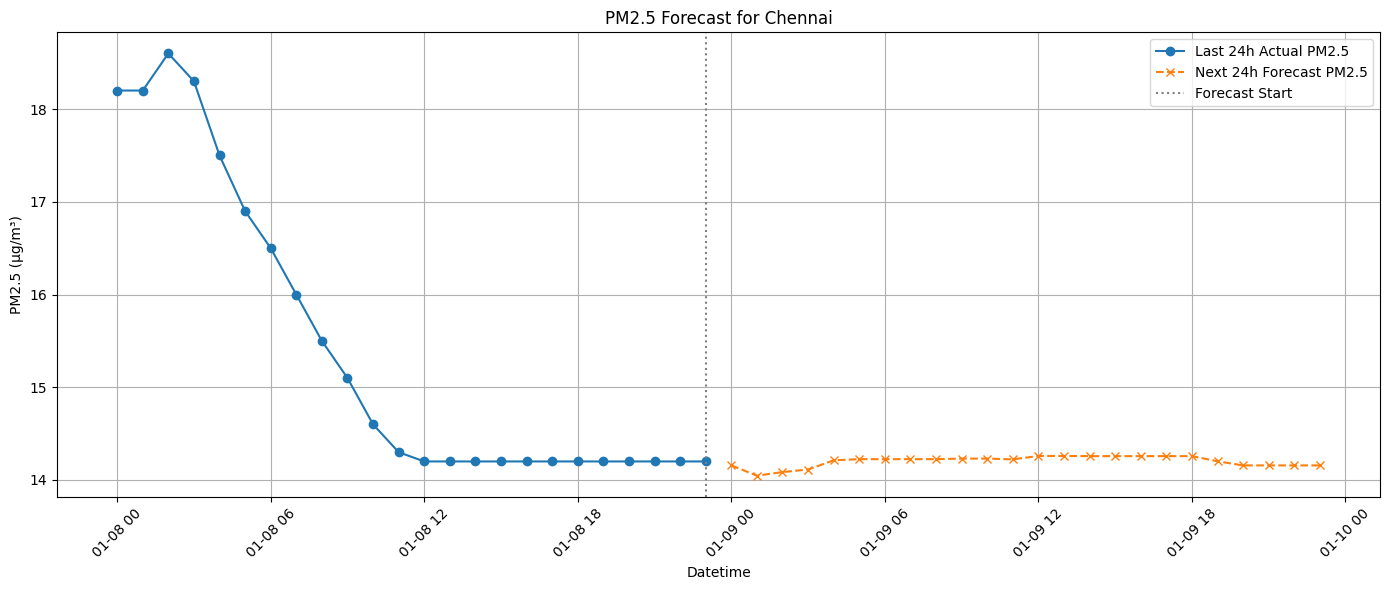

In [ ]:
# ==================================
# CELL 12: ACTUAL VS FORECAST
# ==================================

import matplotlib.pyplot as plt

region_name = "Chennai"

# Last 24 hours actual PM2.5
actual_24h = (
    feature_df[feature_df["region"] == region_name]
    .sort_values("datetime")
    .tail(24)
)

# Forecast (next 24 hours)
forecast_24h = forecast_24h.copy()

plt.figure(figsize=(14,6))

plt.plot(
    actual_24h["datetime"],
    actual_24h["pm25"],
    label="Last 24h Actual PM2.5",
    marker="o"
)

plt.plot(
    forecast_24h["datetime"],
    forecast_24h["predicted_pm25"],
    label="Next 24h Forecast PM2.5",
    marker="x",
    linestyle="--"
)

plt.axvline(
    actual_24h["datetime"].iloc[-1],
    color="gray",
    linestyle=":",
    label="Forecast Start"
)

plt.xlabel("Datetime")
plt.ylabel("PM2.5 (µg/m³)")
plt.title(f"PM2.5 Forecast for {region_name}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Anomaly Detection Visualization

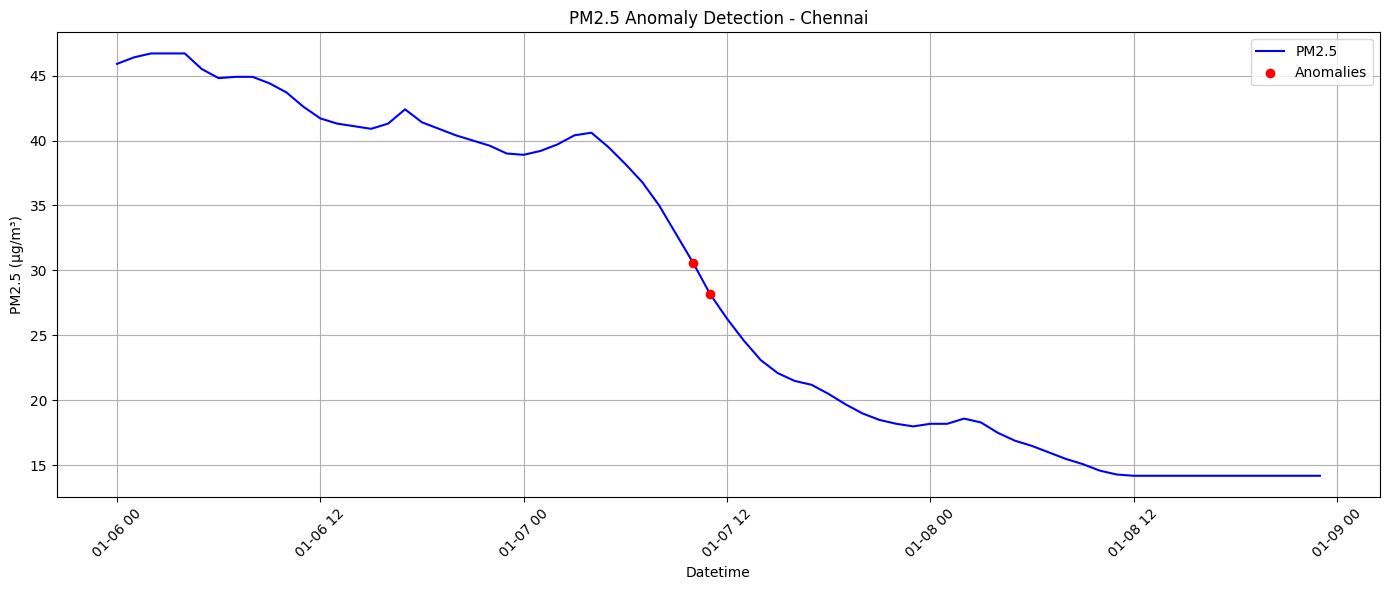

In [ ]:
# ==================================
# CELL 13: ANOMALY VISUALIZATION
# ==================================

region_data = (
    feature_df[feature_df["region"] == region_name]
    .sort_values("datetime")
    .tail(72)
)

plt.figure(figsize=(14,6))

plt.plot(
    region_data["datetime"],
    region_data["pm25"],
    label="PM2.5",
    color="blue"
)

anomalies = region_data[region_data["anomaly_flag"] == 1]

plt.scatter(
    anomalies["datetime"],
    anomalies["pm25"],
    color="red",
    label="Anomalies",
    zorder=5
)

plt.xlabel("Datetime")
plt.ylabel("PM2.5 (µg/m³)")
plt.title(f"PM2.5 Anomaly Detection - {region_name}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


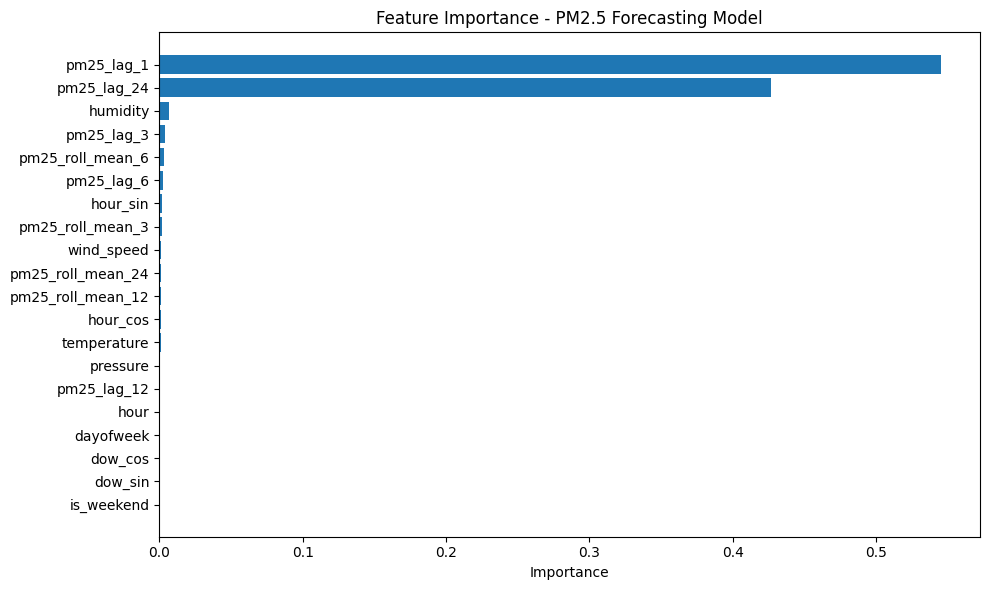

,feature,importance
0,pm25_lag_1,0.545354
4,pm25_lag_24,0.426595
10,humidity,0.006393
1,pm25_lag_3,0.003718
6,pm25_roll_mean_6,0.003229
2,pm25_lag_6,0.002206
16,hour_sin,0.002190
5,pm25_roll_mean_3,0.002103
11,wind_speed,0.001423
8,pm25_roll_mean_24,0.001340


In [ ]:
# ==================================
# CELL 14: FEATURE IMPORTANCE
# ==================================

import pandas as pd
import numpy as np

feature_importance = pd.DataFrame({
    "feature": feature_columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"]
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance - PM2.5 Forecasting Model")
plt.tight_layout()
plt.show()

feature_importance.head(10)
